In [1]:
from backend.daps.data import Devices, Speakers
from backend.daps.loader import DAPSLoader
from backend.audio_to_spectrogram_converter import AudioToSpectrogramConverter
from backend.tsrc.loader import TSRCLoader
from backend.tsrc.data import Environments

import PIL
import seaborn as sns
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np

from ipywidgets import widgets
from ipywidgets import interactive
from IPython.display import Audio

%load_ext autoreload
%autoreload 2

sns.set_theme(rc={'figure.figsize':(20,6)})

In [2]:
#audio_data = DAPSLoader('../data/daps').get_audio(devices=[Devices.ipad], speakers=[Speakers.f1])
#AudioToSpectrogramConverter().convert(audio_data[0]).show()

In [3]:
audio_data = TSRCLoader('../data/tsrc').get_audio([Environments.cat, Environments.dog, Environments.bed, Environments.bird, Environments.down, Environments.eight])

In [4]:
enviroment_counts = {}
tag_list = []
sample_len_list = []
sample_rate_list = []
speaker_id_list = []
repetition_no_list = []


for audio in audio_data:
    tag_list.append(audio.tag)
    sample_len_list.append(len(audio.samples))
    sample_rate_list.append(audio.sample_rate)
    speaker_id_list.append(audio.speaker_id)
    repetition_no_list.append(audio.repetition_no)
    
df = pd.DataFrame({"tag": tag_list, 
                   "sample_len": sample_len_list, 
                   "sample_rate": sample_rate_list, 
                   "speaker_id": speaker_id_list,
                   "repetition_no" : repetition_no_list})
df['audio_length'] = df['sample_len'] / df['sample_rate']

<div style="text-align:center;
            font-size:30px;
            border-bottom:solid">
    Overall statistics
    </div>

In [5]:
print(f"Audio files: {len(audio_data)}")
print(f"Mean audio length: {df.audio_length.mean()}s")
print(f"Number of unique speakers in train dataset: {len(df.speaker_id.unique())}")

Audio files: 11634
Mean audio length: 0.9831877283604978s
Number of unique speakers in train dataset: 1818


<div style="text-align:center;
            font-size:30px;
            border-bottom:solid">
    Samples by enviroment
    </div>

<Axes: xlabel='tag', ylabel='count'>

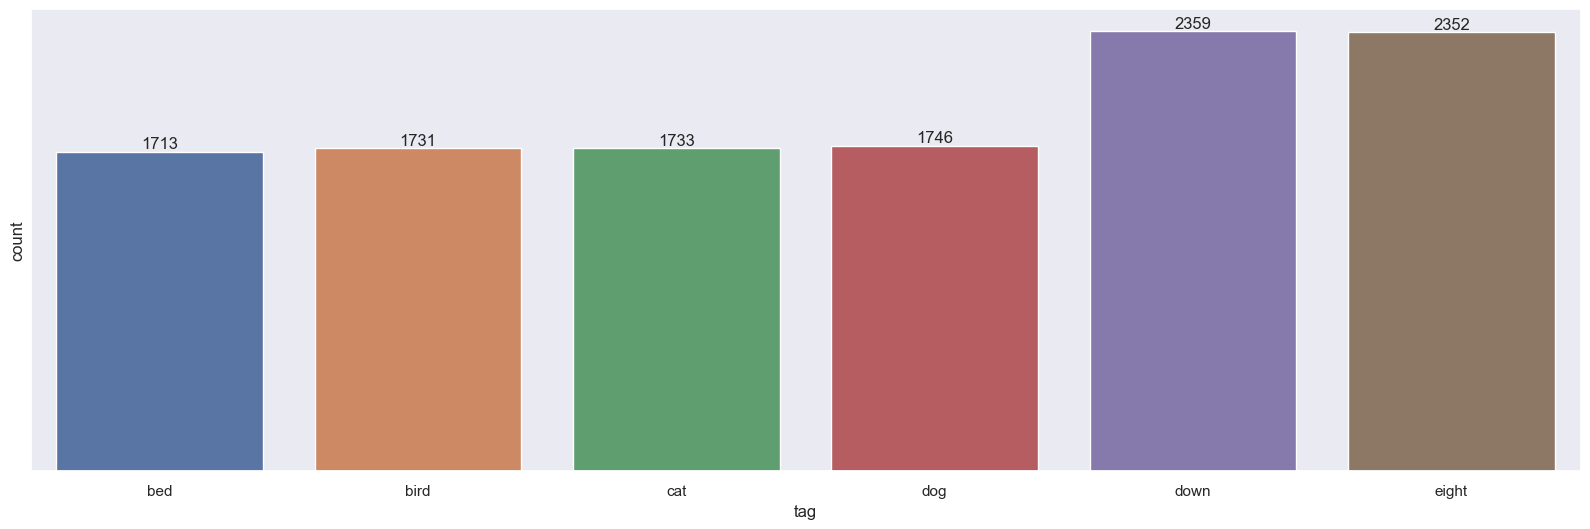

In [6]:
count_df = df.groupby("tag", as_index=False).agg(count=('tag', 'count'))

ax = sns.barplot(count_df, x="tag", y="count")
ax.bar_label(ax.containers[0])
ax.set_yticks([], [])
ax

<div style="text-align:center;
            font-size:30px;
            border-bottom:solid">
    Length of audio clips
    </div>

In [7]:
tag_widget = widgets.SelectMultiple(
    options=list(df['tag'].unique()),
    value=list(df['tag'].unique()),
    #rows=10,
    description='tag'
)

def plot_length(tag):
    """
    Makes violin plot
    Args:
        tag (List[str]): A list of tags to plot
    """
    df2 = df.copy()
    df2 = df2[df2.tag.isin(tag)]

    # Plot it (only if there's data to plot)
    if len(df2) > 0:
        sns.violinplot(df2, x = "tag", y="audio_length").set_title("Length of audio by tag")
        plt.show();
    else:
        print("No data to show for current selection")

In [8]:
interactive(plot_length, tag = tag_widget)

interactive(children=(SelectMultiple(description='tag', index=(0, 1, 2, 3, 4, 5), options=('cat', 'dog', 'bed'…

In [9]:
def plot_length_hist(tag):
    """
    Makes histogram of length of audio files.
    Args:
        tag (List[str]): A list of tags to plot
    """
    df2 = df.copy()
    df2['audio_length'] = df2['audio_length'].round(3)
    df2 = df2[df2.tag.isin(tag)]

    # Plot it (only if there's data to plot)
    if len(df2) > 0:
        sns.histplot(df2,x="audio_length").set_title("Length of audio by tag")
        plt.show();
    else:
        print("No data to show for current selection")

In [10]:
#TODO: maybe delete this. Obsolete with violin plot above

In [11]:
interactive(plot_length_hist, tag = tag_widget)

interactive(children=(SelectMultiple(description='tag', index=(0, 1, 2, 3, 4, 5), options=('cat', 'dog', 'bed'…

<div style="text-align:center;
            font-size:30px;
            border-bottom:solid">
    Repetitions of speakers
    </div>

In [12]:
def plot_repetitions(tag):
    """
    Plots count of number of repetitions
    Args:
        tag (List[str]): A list of tags to plot
    """
    df2 = df.copy()
    df2 = (
        df2
        .groupby(["speaker_id", "tag"], as_index=False)
        .agg(no_repetitions=('tag', 'count'))
        .groupby(["tag", "no_repetitions"], as_index=False)
        .agg(count=('no_repetitions', 'sum'))
    )
    
    if not (list(tag) == list(df['tag'].unique())):
        df2 = df2[df2.tag.isin(tag)]
    else:
        df2 = (
            df2
            .groupby(["no_repetitions"], as_index=False)
            .agg(count=('count', 'sum'))
        )

    # Plot it (only if there's data to plot)
    if len(df2) > 0:
        sns.barplot(df2,x="no_repetitions", y="count").set_title("Length of audio by tag")
        plt.show();
    else:
        print("No data to show for current selection")

In [13]:
interactive(plot_repetitions, tag = tag_widget)

interactive(children=(SelectMultiple(description='tag', index=(0, 1, 2, 3, 4, 5), options=('cat', 'dog', 'bed'…

<div style="text-align:center;
            font-size:30px;
            border-bottom:solid">
    Samples of words
    </div>

In [14]:
def sample_plots(tags: list[str], no_samples : int):
    """
    Plots samples of specified tags
    Args:
        tags (List[str]): A list of tags to sample from
        no_samples (int): Number of samples to take from each tag
    """
    fig, axes = plt.subplots(no_samples,len(tags))
    all_samples_indexes = {}
    
    for col, tag in enumerate(tags):
        df2 = df.copy()
        samples_index = list(df2[df2.tag == tag].sample(no_samples).index)
        
        for row, sample in enumerate(samples_index):
            all_samples_indexes[f"{tag}{row}"] = sample
            
            img = AudioToSpectrogramConverter().convert_to_bytes(audio_data[sample], dpi=100)
            img_array = np.array(PIL.Image.open(img))
            axes[row, col].imshow(img_array)
            axes[row, col].grid(False)
            
            #axes[row, col].set_ylabel(f"sample {row}", rotation=0, size='large')
            axes[row, col].set_title(tag)
            
    return fig, all_samples_indexes

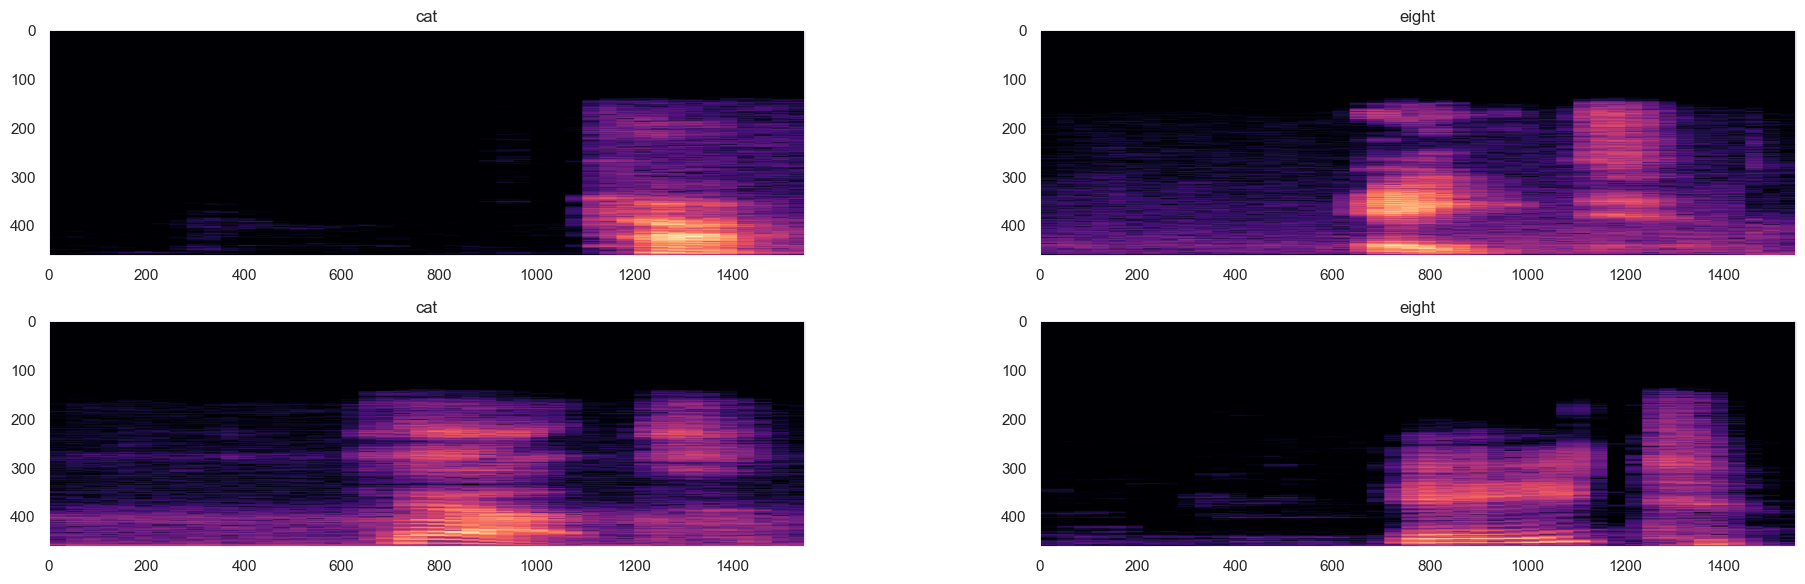

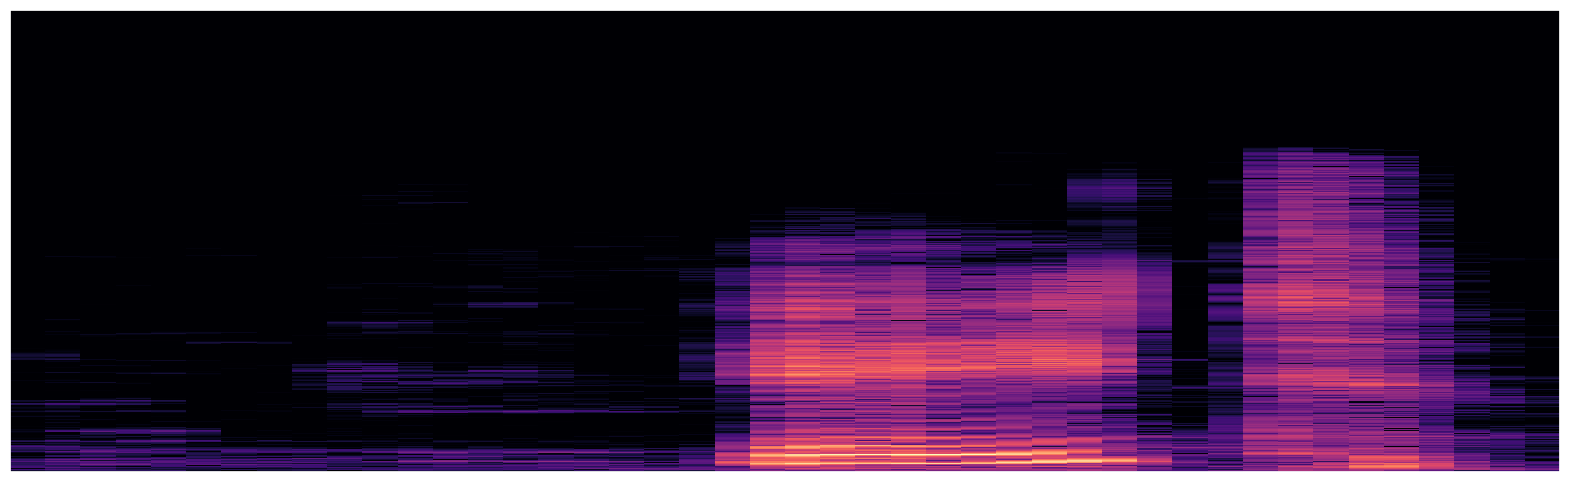

In [15]:
#TODO: fig does not display correctly
fig, samples_index = sample_plots(["cat", "eight"], 2)
fig.tight_layout()
fig

In [16]:
selected_sample = widgets.Dropdown(
    options=list(samples_index.keys()),
    value=list(samples_index.keys())[0],
    description='tag'
)
selected_sample

Dropdown(description='tag', options=('cat0', 'cat1', 'eight0', 'eight1'), value='cat0')

In [18]:
listen_index = samples_index[selected_sample.value]
Audio(audio_data[listen_index].samples, rate=audio_data[listen_index].sample_rate)